In [1]:
import sys
path_append = "../"
sys.path.append(path_append)  # Go up one directory from where you are.

In [2]:
import os

# Paths
dataroot = path_append +  "../data/"
path = os.path.join(dataroot, "pokemon/images/")
image_size = 128

In [3]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset

def preprocess_images(source_dir, image_size):
    processed_images = []
    
    for img_name in os.listdir(source_dir):
        if os.path.isfile(os.path.join(source_dir, img_name)):
            image_path = os.path.join(source_dir, img_name)
            image = Image.open(image_path).convert('RGB')

            # Find the most common color
            img_array = np.array(image)
            colors, counts = np.unique(img_array.reshape(-1, 3), axis=0, return_counts=True)
            most_common_color = colors[counts.argmax()]
            mask = np.all(img_array == most_common_color, axis=-1)
            img_array[mask] = [255, 255, 255]

            # Convert the numpy array back to an Image object and resize
            processed_image = Image.fromarray(img_array)
            processed_image = processed_image.resize((image_size, image_size))
            processed_images.append(processed_image)
    
    return processed_images

class PokemonDataset(torch.utils.data.Dataset):
    def __init__(self, processed_images):
        self.images = processed_images
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __getitem__(self, index):
        # Apply transformations to the PIL Image
        image = self.transform(self.images[index])
        return image, None  # Assuming no labels are associated

    def __len__(self):
        return len(self.images)

In [4]:
processed_images = preprocess_images(path, image_size)
dataset = PokemonDataset(processed_images)

# Load the first image and check shape
first_image, y = dataset[0]
print(f"Input shape: {first_image.shape}")
print(f"Total number of images in dataset: {len(dataset)}")

c:\Users\CCNets-team\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Input shape: torch.Size([3, 128, 128])
Total number of images in dataset: 809


In [5]:
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig

data_config = DataConfig(dataset_name = 'poketmon', task_type='generation', obs_shape=[3, 128, 128], label_size=0, \
                        show_image_indices=[517, 95, 321, 437])
#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(core_model = 'none', encoder_model = 'stylegan')

ml_params.model.encoder_config.d_model = 256
ml_params.model.encoder_config.num_layers = 5
ml_params.model.encoder_config.dropout = 0.0
ml_params.optimization.decay_rate_100k = 0.05
ml_params.training.num_epoch = 1000

c:\Users\CCNets-team\anaconda3\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
from trainer_hub import TrainerHub

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the TrainerHub class with the training configuration, data configuration, device, and use_print and use_wandb flags
trainer_hub = TrainerHub(ml_params, data_config, device, use_print=True, use_wandb=False)


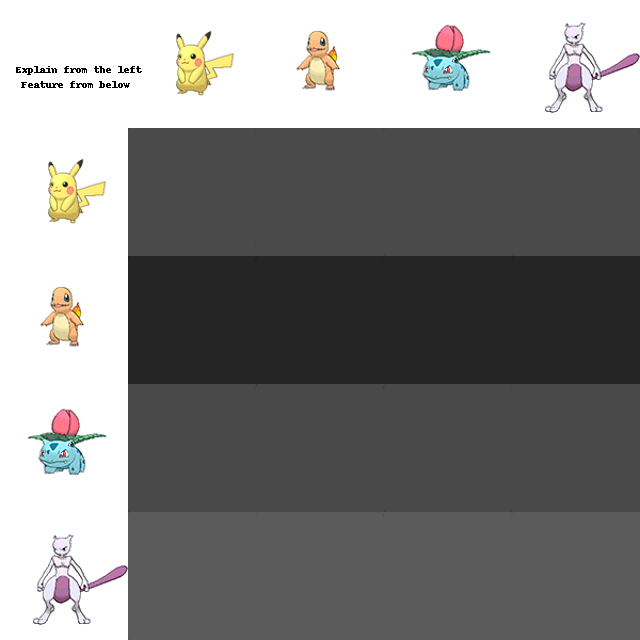

[195/1000][10/12][Time 5.90]
Unified LR across all optimizers: 0.00018639865765368338
--------------------Training Metrics--------------------
Trainer:  stylegan
Inf: 0.1278	Gen: 0.0846	Rec: 0.1271	E: 0.0853	R: 0.1702	P: 0.0839


In [7]:
trainer_hub.train(dataset)